In [54]:
import os
import io
import operator
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso, ElasticNet, Ridge, LogisticRegression
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import pickle

%matplotlib inline



file="all_words/"

# Functions to extract the data and put it as a DataFrame

In [55]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

def sorted_dictionary(folder):
    len_file={}
    for filename in os.listdir(folder):
        len_file[filename]=file_len(folder+filename)
    sorted_len_file=sorted(len_file.items(), key=lambda x: -x[1])
    return sorted_len_file

In [56]:
def create_list(fname):
    l=[]
    fname=fname
    file=open(fname,'r')
    file=file.readlines()
    for e in file:
        e=e.replace(' ','')
        e=e[:-1].split(',')
        ideology=float(e[0])
        count=int(e[1])
        freq1=float(e[2])
        freq2=float(e[3])
        duration=float(e[4])
        F11=float(e[5])
        F12=float(e[6])
        F13=float(e[7])
        F21=float(e[8])
        F22=float(e[9])
        F23=float(e[10])
        if ideology!=0.0 and ideology!=1.0:
            l.append([ideology,count,freq1,freq2,duration,F11,F12,F13,F21,F22,F23])
    return l       

In [57]:
def create_dataset(folder,file):
    l_df=create_list(folder+file)
    col=['Ideology','Count','Freq1','Freq2','Duration','F11','F12','F13','F21','F22','F23']
    df=pd.DataFrame(l_df)
    df.columns=col
    y=df['Ideology']
    x=df.drop('Ideology',axis=1)
    x=x.drop('Count',axis=1)
    y[y>0.5]=1
    y[y<0.5]=0
    return x,y

# Functions to extract the score for each regressor and find the optimal regularization

In [58]:
def score_regressor(regressor,x,y,lambdas,split_size=5):
    if split_size>len(y):
        if len(y)>1:
            split_size=len(y)
        else:
            return -1
    scores=[]
    kf=KFold(n_splits=split_size)
    for train_index, test_index in kf.split(x):
        history=[]
        X_train, X_test = x.T[train_index].T, x.T[test_index].T
        y_train, y_test = y.T[train_index].T, y.T[test_index].T
        for i in range(len(lambdas)):
            l=lambdas[i]
            if regressor=='Lasso':
                lr=Lasso(alpha=l,normalize=True)
            elif regressor=='Ridge':
                lr=Ridge(alpha=l,normalize=True)
            else:
                lr=LogisticRegression(C=1/l)
                y_train=y_train.astype(int)
                y_test=y_test.astype(int)
            lr.fit(X_train,y_train)
            score=lr.score(X_test,y_test)
            history.append(score)
        scores.append(history)
    s_reg=np.zeros(len(lambdas))
    for e in scores:
        for i in range(len(e)):
            s_reg[i]+=e[i]/len(scores)
    return s_reg

def score_lasso_ridge_elastic(x,y,lambdas,split_size=5):
    s_lasso=score_regressor('Lasso',x,y,lambdas,split_size)
    s_ridge=score_regressor('Ridge',x,y,lambdas,split_size)
    s_elastic=score_regressor('Elastic',x,y,lambdas,split_size)
    return s_lasso,s_ridge,s_elastic

In [59]:
def optimal_lambda(s_lasso,s_ridge,s_elastic):
    lambda_lasso=lambdas[list(s_lasso).index(max(s_lasso))]
    lambda_ridge=lambdas[list(s_ridge).index(max(s_ridge))]
    #lambda_elastic=lambdas[list(s_elastic).index(max(s_elastic))]
    #print('The lambdas we will choose are \n lambda_lasso='+str(lambda_lasso)+'\n lambda_ridge='+str(lambda_ridge)+'\n lambda_elastic='+str(lambda_elastic))
    return lambda_lasso,lambda_ridge,lambda_ridge

# Let's run this on an example

In [60]:
sorted_len_file=sorted_dictionary(file)

The format of this dictionary is the following:

$$(\text{file name},\text{instances in that file})$$

Here are the 5 top entries:

In [61]:
sorted_len_file[:5]

[('JUSTICE_AH_2.0.txt', 457),
 ('JUSTICE_AH_1.0.txt', 457),
 ('BECAUSE_IH_1.0.txt', 456),
 ('BECAUSE_AH_2.0.txt', 450),
 ('UNDER_ER_2.0.txt', 436)]

In [62]:
x,y=create_dataset(file,sorted_len_file[10][0])

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Here are the first ten entries of the resulting $X$:

In [63]:
x.head(10)

,Freq1,Freq2,Duration,F11,F12,F13,F21,F22,F23
0,534.166667,1854.666667,0.059667,535.000000,526.333333,507.166667,1858.000000,1765.333333,1838.166667
1,549.716981,1643.830189,0.071830,590.490566,602.490566,669.075472,1678.754717,1682.679245,1727.622642
2,508.000000,1687.500000,0.035000,507.500000,502.000000,506.500000,1688.000000,1689.500000,1699.500000
3,519.500000,1667.000000,0.105500,517.500000,504.500000,467.000000,1657.500000,1703.000000,1804.000000
4,588.090909,1761.272727,0.060636,595.090909,591.727273,704.363636,1747.000000,1806.363636,1825.272727
5,568.750000,1648.750000,0.052750,576.000000,567.250000,556.750000,1667.250000,1639.750000,1665.500000
6,528.666667,1784.000000,0.046667,528.333333,531.000000,543.333333,1791.666667,1756.666667,1774.333333
7,697.666667,1946.333333,0.040000,699.333333,673.000000,980.666667,1937.000000,1910.000000,2064.333333
8,552.000000,1827.000000,0.095500,544.000000,582.500000,624.000000,1840.000000,1832.000000,1884.000000
9,465.000000,1736.500000,0.049500,454.000000,459.000000,416.500000,1745.000000,1735.500000,1763.000000


and the first ten entries of $Y$:

In [64]:
y.head(10)

0    0.0
1    1.0
2    0.0
3    0.0
4    1.0
5    1.0
6    0.0
7    0.0
8    0.5
9    0.0
Name: Ideology, dtype: float64

In [65]:
lambdas=np.arange(1e-3,4e-2,1e-3)
s_lasso,s_ridge,s_elastic=score_lasso_ridge_elastic(x,y,lambdas)

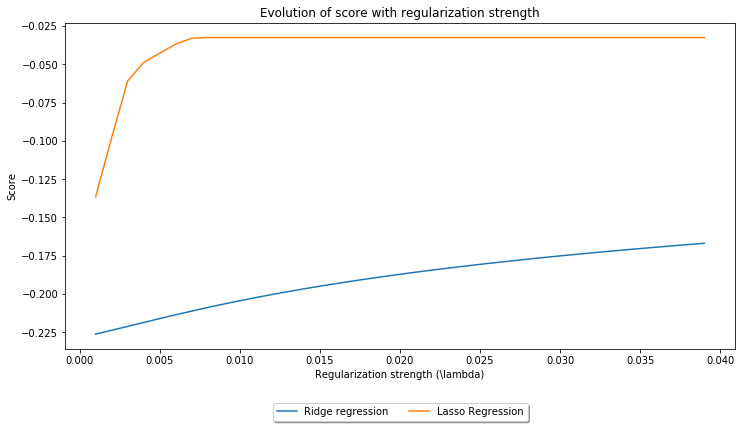

In [66]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)
plt.plot(lambdas,s_ridge,label='Ridge regression')
plt.plot(lambdas,s_lasso,label='Lasso Regression')
plt.xlabel('Regularization strength (\lambda)')
plt.ylabel('Score')
plt.title('Evolution of score with regularization strength')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

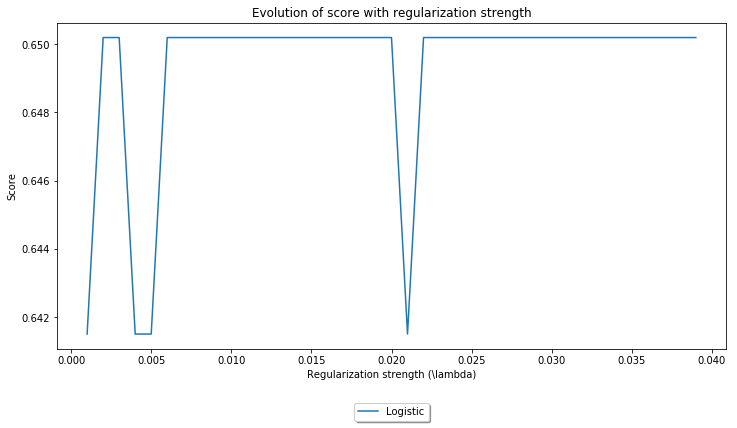

In [67]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)
plt.plot(lambdas,s_elastic,label='Logistic')
plt.xlabel('Regularization strength (\lambda)')
plt.ylabel('Score')
plt.title('Evolution of score with regularization strength')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

In [68]:
lambda_lasso,lambda_ridge,lambda_elastic=optimal_lambda(s_lasso,s_ridge,s_elastic)

# Functions to compute F1 score and Accuracy

In [69]:
def optimal_cut(y_true,y_predict):
    a=min(y_predict)
    b=max(y_predict)
    c=a
    threshold=c
    accuracy=0
    loop=True
    while c<b:
        c=c+0.1
        y_compare=np.copy(y_predict)
        y_compare[y_compare>c]=1
        y_compare[y_compare<=c]=0
        y_compare=y_compare.astype(int)
        y_true=y_true.astype(int)
        acc=skm.accuracy_score(y_true,y_compare)
        if acc>accuracy:
            threshold=c
    return threshold
            

In [70]:
def Accuracy_regressor(type_of_regressor,x,y,lambda_reg,split_size=5):
    if split_size>len(y):
        if len(y)>1:
            split_size=len(y)
        else:
            return -1
        split_size=len(y)
    kf=KFold(n_splits=split_size)
    accuracy=0
    f1=0
    for train_index, test_index in kf.split(x):
        history=[]
        X_train, X_test = x.T[train_index].T, x.T[test_index].T
        y_train, y_test = y.T[train_index].T, y.T[test_index].T
        if type_of_regressor=='Ridge':
            lr=Ridge(alpha=lambda_reg,normalize=False)
        elif type_of_regressor=='Lasso':
            lr=Lasso(alpha=lambda_reg,normalize=False)
        else:
            lr=LogisticRegression(C=1/lambda_reg)
            y_train=y_train.astype(int)
            y_test=y_test.astype(int)
        lr.fit(X_train,y_train)
        y_predict=lr.predict(X_test)
        y_train_predicted=lr.predict(X_train)
        threshold=optimal_cut(y_train,y_train_predicted)
        y_predict[y_predict>threshold]=1
        y_predict[y_predict<=threshold]=0
        y_predict=y_predict.astype(int)
        y_test=y_test.astype(int)
        y_predict=list(y_predict)
        y_test=list(y_test)
        f1_score=skm.f1_score(y_test,y_predict)
        acc=0
        acc=skm.accuracy_score(y_test,y_predict)
        accuracy+=acc
        f1+=f1_score
    return accuracy/split_size, f1/split_size

def Accuracy_lasso_ridge_elastic(x,y,lambda_lasso=lambda_lasso,lambda_ridge=lambda_ridge,lambda_elastic=lambda_elastic,split_size=5):
    lasso_acc,lasso_f1=Accuracy_regressor('Lasso',x,y,lambda_lasso,split_size)
    ridge_acc,ridge_f1=Accuracy_regressor('Ridge',x,y,lambda_ridge,split_size)
    log_acc,log_f1=Accuracy_regressor('Elastic',x,y,lambda_elastic,split_size)
    return lasso_acc,lasso_f1,ridge_acc,ridge_f1,log_acc,log_f1

In [71]:
#Find the optimal k for the corss-validation
#acc_lasso=[]
#acc_ridge=[]
#acc_ela=[]
#range_k=range(2,20,1)
#for k in range_k:
#    lasso=Accuracy_regressor('Lasso',x,y,split_size=k)
#    ridge=Accuracy_regressor('Ridge',x,y,split_size=k)
#    ela=Accuracy_regressor('Elastic',x,y,split_size=k)
#    acc_lasso.append(lasso)
#    acc_ridge.append(ridge)
#    acc_ela.append(ela)
#plt.plot(acc_ela)

# Function to get accuracy on all files

Function that returns the accuracy for each regressor for each file in the following lists:

$$\text{acc_lasso},\text{acc_ridge},\text{acc_ela}$$

returns dictionaries for each type of regression:

$$\text{d_lasso},\text{d_ridge},\text{d_ela}$$

The keys are the size of the input, the values are the accuracies and f1 scores for a given input size.

also return $\text{x_axis}$ which contains in the correct order the length of each file, which is useful when we try to plot the figures later

In [76]:
lambdas=np.arange(1e-3,4e-2,1e-3)
def accuracy_on_all_files(folder):
    sorted_len_file=sorted_dictionary(folder)
    k=0
    results={}
    size={}
    for file in sorted_len_file:
        results[folder+file[0]]=[]
        size[folder+file[0]]=file_len(folder+file[0])
    for file in sorted_len_file:
        try:
            if k%100==0:
                print(str(100*k/len(sorted_len_file))+"% complete")
            n=size[folder+file[0]]
            if n<4:
                del results[folder+file[0]]
                del size[folder+file[0]]
            else:
                x,y=create_dataset(folder,file[0])
                s_lasso, s_ridge, s_elastic=score_lasso_ridge_elastic(x,y,lambdas)
                lambda_lasso,lambda_ridge,lambda_elastic=optimal_lambda(s_lasso, s_ridge, s_elastic)
                lasso_acc,lasso_f1,ridge_acc,ridge_f1,log_acc,log_f1=Accuracy_lasso_ridge_elastic(x,y,lambda_lasso,lambda_ridge,lambda_elastic)
                results[folder+file[0]]=[lasso_acc,lasso_f1,ridge_acc,ridge_f1,log_acc,log_f1]
                k+=1
        except ValueError:
            oops=1
        except TypeError:
            oops=1
    return results, size

# Functions to average the accuracy for each key in the dictionaries and functions to plot the results obtained from accuracy_on_all_files

In [77]:
def average_dictionaries(results, size):
    d_average_acc={}
    d_average_f1={}
    for key in size:
        n=size[key]
        lasso_acc,lasso_f1,ridge_acc,ridge_f1,log_acc,log_f1=results[key]
        acc=[1,lasso_acc,ridge_acc,log_acc]
        f1=[1,lasso_f1,ridge_f1,log_f1]
        if n in d_average_acc:
            d_average_acc[n]=[d_average_acc[n][i]+acc[i] for i in range(len(acc))]
        else:
            d_average_acc[n]=acc
        if n in d_average_f1:
            d_average_f1[n]=[d_average_f1[n][i]+f1[i] for i in range(len(f1))]
        else:
            d_average_f1[n]=f1
    for key in d_average_acc:
        acc=d_average_acc[key]
        acc[1]=acc[1]/acc[0]
        acc[2]=acc[2]/acc[0]
        acc[3]=acc[3]/acc[0]
        d_average_acc[key]=acc
    for key in d_average_f1:
        acc=d_average_f1[key]
        acc[1]=acc[1]/acc[0]
        acc[2]=acc[2]/acc[0]
        acc[3]=acc[3]/acc[0]
        d_average_f1[key]=acc
    return d_average_acc, d_average_f1

# Let's now apply those functions to evaluate how we perform on ideologically charged words

<Container object of 315 artists>

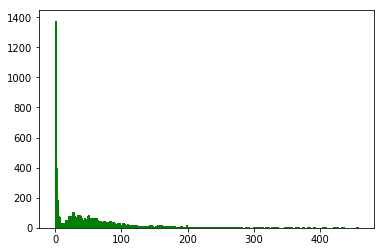

In [78]:
d={}
for i in sorted_len_file:
    try:
        d[i[1]]+=1
    except KeyError:
        d[i[1]]=1
plt.bar(d.keys(), d.values(), width=4, color='g')

In [79]:
results, size=accuracy_on_all_files(file)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alp

0.0% complete
1.309757694826457% complete
2.619515389652914% complete
3.9292730844793713% complete
5.239030779305828% complete
6.5487884741322855% complete
7.858546168958743% complete
9.1683038637852% complete
10.478061558611657% complete
11.787819253438114% complete
13.097576948264571% complete
14.407334643091028% complete
15.717092337917485% complete
17.026850032743944% complete
18.3366077275704% complete
19.64636542239686% complete
20.956123117223314% complete
22.265880812049772% complete
23.575638506876228% complete
24.885396201702687% complete
26.195153896529142% complete
27.5049115913556% complete
28.814669286182056% complete
30.124426981008515% complete
31.43418467583497% complete
32.74394237066143% complete
34.05370006548789% complete
35.36345776031434% complete
36.6732154551408% complete
37.98297314996726% complete
39.29273084479372% complete
40.60248853962017% complete
41.91224623444663% complete
43.222003929273086% complete
44.531761624099545% complete
45.841519318926% compl

//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [147]:
pickle.dump( results, open( "new_results_not normalized.p", "wb" ) )

In [148]:
#results = pickle.load( open( "results.p", "rb" ) )
#size = pickle.load( open( "size.p", "rb" ) )
print(len(results))
results_final={}
size_final={}
for e in results:
    if results[e]!=[]:
        results_final[e]=results[e]
        size_final[e]=size[e]
results=results_final
size=size_final
print(len(results_final))

5675
5391


In [149]:
d_average_acc, d_average_f1=average_dictionaries(results, size)

In [150]:
pickle.dump( results, open( "results_acc_skl.p", "wb" ) )
pickle.dump(size,open( "size_acc_skl.p", "wb" ) )


In [151]:
acc_lasso=[]
acc_ridge=[]
acc_log=[]
for i in d_average_acc:
    entry=d_average_acc[i]
    acc_lasso.append(entry[1])
    acc_ridge.append(entry[2])
    acc_log.append(entry[3])

In [152]:
f1_lasso=[]
f1_ridge=[]
f1_log=[]
for i in d_average_f1:
    entry=d_average_f1[i]
    f1_lasso.append(entry[1])
    f1_ridge.append(entry[2])
    f1_log.append(entry[3])

In [153]:
x_axis=[]
acc_lasso_allpoints=[]
acc_ridge_all=[]
acc_log_all=[]
f1_lasso_all=[]
f1_ridge_all=[]
f1_log_all=[]
for i in results:
    entry=results[i]
    nb=size[i]
    try:
        acc_lasso_allpoints.append(entry[0])
        acc_ridge_all.append(entry[2])
        acc_log_all.append(entry[4])
        f1_lasso_all.append(entry[1])
        f1_ridge_all.append(entry[3])
        f1_log_all.append(entry[5])
        x_axis.append(nb)
    except IndexError:
        pass
    

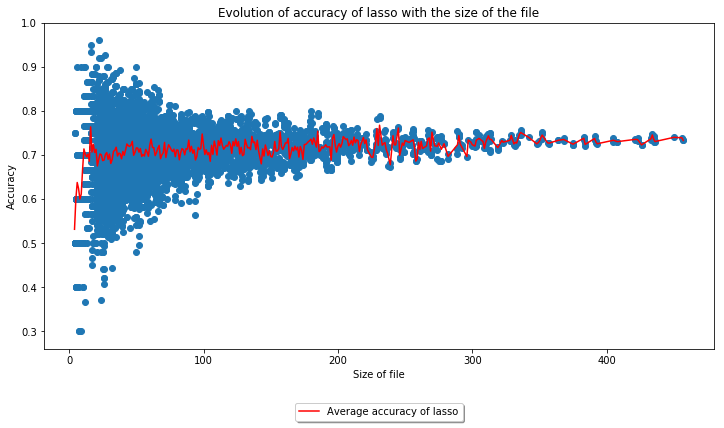

In [154]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)
plt.scatter(x_axis,acc_lasso_allpoints)
plt.plot(list(d_average_acc.keys()),acc_lasso,color='r',label='Average accuracy of lasso',)
plt.xlabel('Size of file')
plt.ylabel('Accuracy')
plt.title('Evolution of accuracy of lasso with the size of the file')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

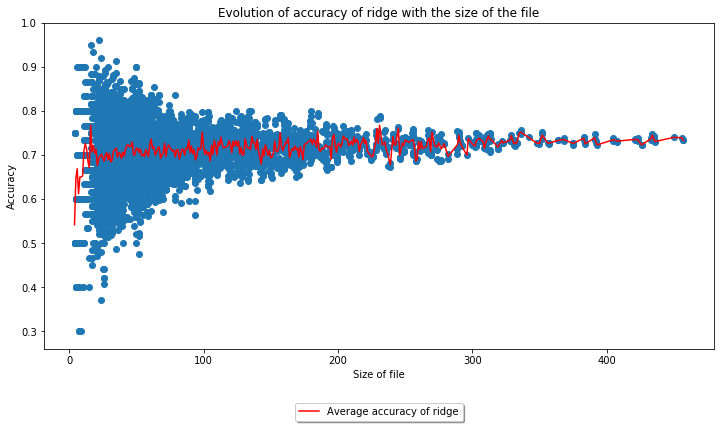

In [155]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)
plt.scatter(x_axis,acc_ridge_all)
plt.plot(list(d_average_acc.keys()),acc_ridge,color='r',label='Average accuracy of ridge',)
plt.xlabel('Size of file')
plt.ylabel('Accuracy')
plt.title('Evolution of accuracy of ridge with the size of the file')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

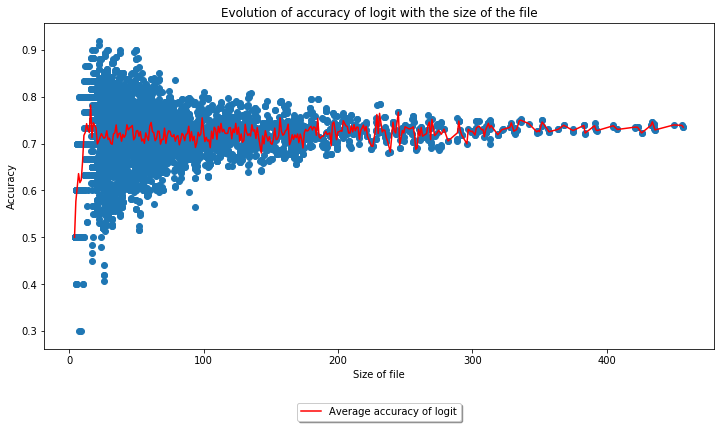

In [156]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)
plt.scatter(x_axis,acc_log_all)
plt.plot(list(d_average_acc.keys()),acc_log,color='r',label='Average accuracy of logit',)
plt.xlabel('Size of file')
plt.ylabel('Accuracy')
plt.title('Evolution of accuracy of logit with the size of the file')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

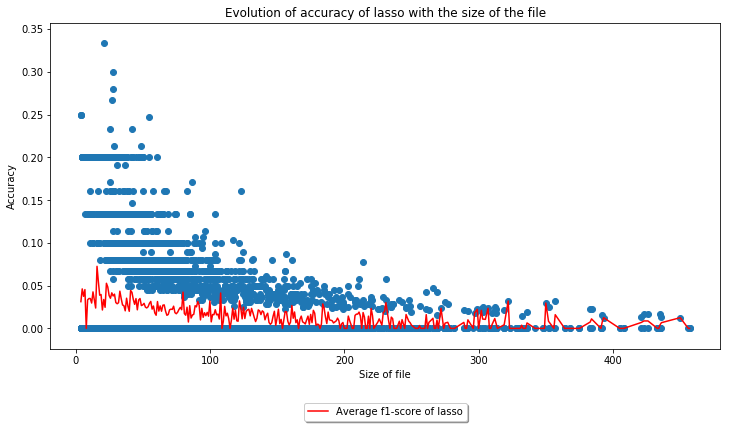

In [157]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)
plt.scatter(x_axis,f1_lasso_all)
plt.plot(list(d_average_f1.keys()),f1_lasso,color='r',label='Average f1-score of lasso',)
plt.xlabel('Size of file')
plt.ylabel('Accuracy')
plt.title('Evolution of accuracy of lasso with the size of the file')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

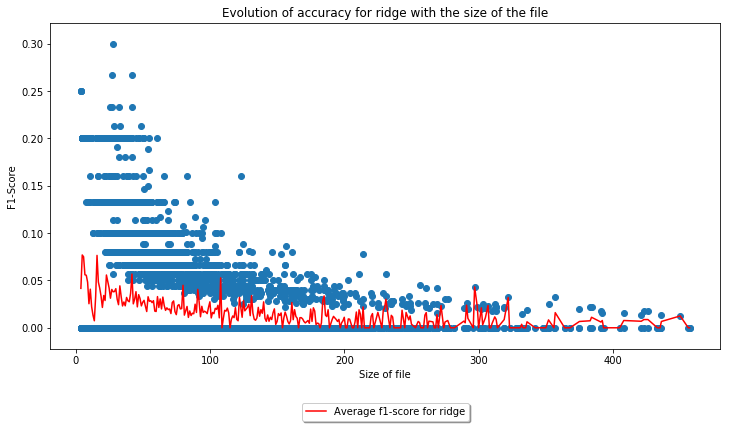

In [158]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)
plt.scatter(x_axis,f1_ridge_all)
plt.plot(list(d_average_f1.keys()),f1_ridge,color='r',label='Average f1-score for ridge',)
plt.xlabel('Size of file')
plt.ylabel('F1-Score')
plt.title('Evolution of accuracy for ridge with the size of the file')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

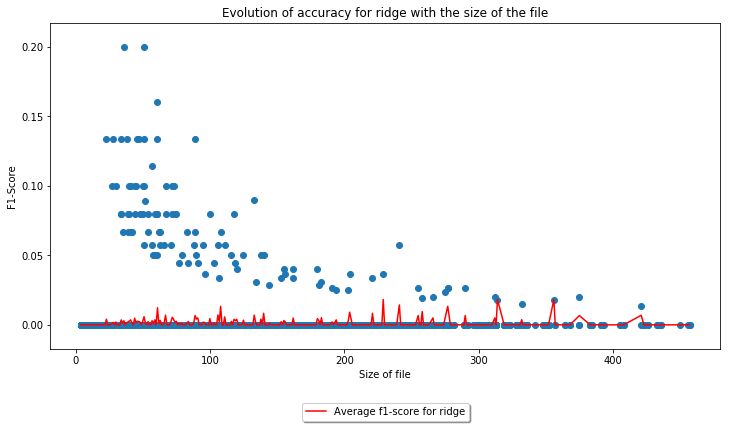

In [159]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)
plt.scatter(x_axis,f1_log_all)
plt.plot(list(d_average_f1.keys()),f1_log,color='r',label='Average f1-score for ridge',)
plt.xlabel('Size of file')
plt.ylabel('F1-Score')
plt.title('Evolution of accuracy for ridge with the size of the file')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

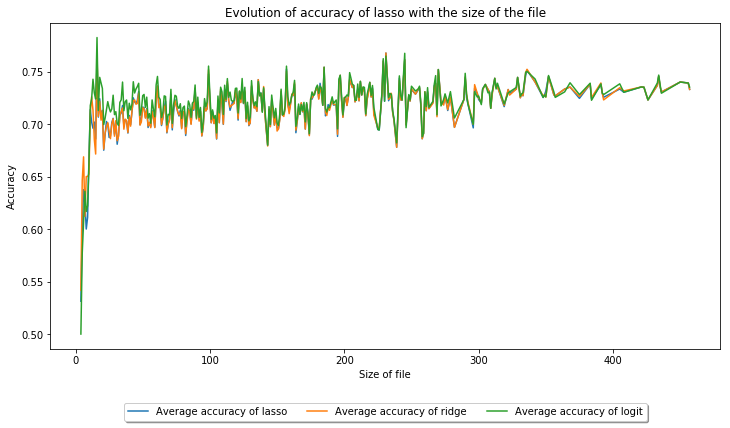

In [160]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)
plt.plot(list(d_average_acc.keys()),acc_lasso,label='Average accuracy of lasso',)

plt.plot(list(d_average_acc.keys()),acc_ridge,label='Average accuracy of ridge',)

plt.plot(list(d_average_acc.keys()),acc_log,label='Average accuracy of logit',)
plt.xlabel('Size of file')
plt.ylabel('Accuracy')
plt.title('Evolution of accuracy of lasso with the size of the file')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

In [161]:
sorted_results_lasso=sorted(results_final.items(), key=lambda e: -(e[1][0]))
sorted_results_ridge=sorted(results_final.items(), key=lambda e: -(e[1][2]))
sorted_results_log=sorted(results_final.items(), key=lambda e: -(e[1][4]))

In [162]:
size_best_performers_las=[]
size_best_performers_rid=[]

size_best_performers_log=[]


acc_lasso_best_perf=[]
acc_ridge_best_perf=[]
acc_log_best_perf=[]

for i in range(len(sorted_results_lasso)):
    las=sorted_results_lasso[i]
    #rid=sorted_results_ridge[i]
    #log=sorted_results_log[i]
    s_las=size[las[0]]
    #s_rid=size[rid[0]]
    #s_log=size[log[0]]
    acc_las=las[1][0]
    acc_rid=las[1][2]
    acc_logit=las[1][4]
    acc_lasso_best_perf.append(acc_las)
    acc_ridge_best_perf.append(acc_rid)
    acc_log_best_perf.append(acc_logit)

    size_best_performers_las.append(s_las)



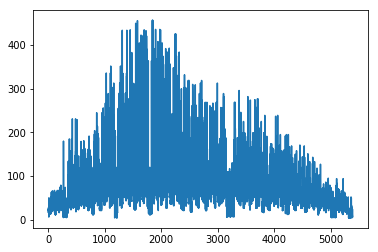

In [163]:
plt.plot(size_best_performers_las)
plt.plot(size_best_performers_rid)

plt.plot(size_best_performers_log)



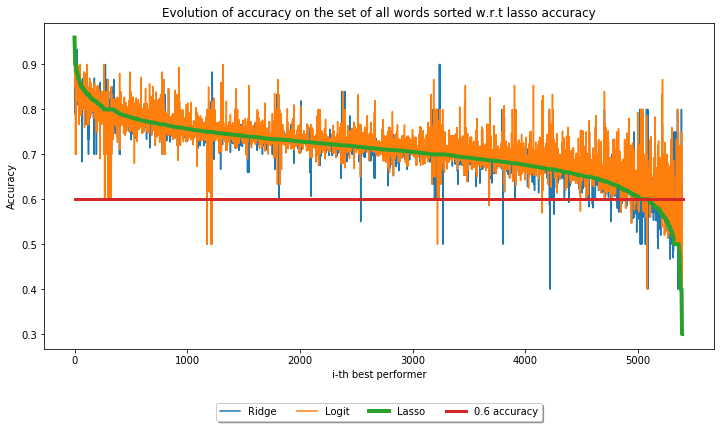

In [164]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)
plt.plot(acc_ridge_best_perf,label='Ridge')

plt.plot(acc_log_best_perf,label='Logit')
plt.plot(acc_lasso_best_perf,label='Lasso',linewidth=4)



plt.plot([0,5400],[0.60,0.6],label='0.6 accuracy',linewidth=3)

plt.xlabel('i-th best performer')
plt.ylabel('Accuracy')
plt.title('Evolution of accuracy on the set of all words sorted w.r.t lasso accuracy')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

More than 5400 of the words we consider allow us to classify well (60% accuracy) , however one good performer for lasso isn't a good performer for ridge or Logit

In [52]:
size_best_performers_las=[]
size_best_performers_rid=[]

size_best_performers_log=[]


acc_lasso_best_perf=[]
acc_ridge_best_perf=[]
acc_log_best_perf=[]

for i in range(len(sorted_results_lasso)):
    #las=sorted_results_lasso[i]
    rid=sorted_results_ridge[i]
    #log=sorted_results_log[i]
    #s_las=size[las[0]]
    s_rid=size[rid[0]]
    #s_log=size[log[0]]
    acc_las=rid[1][0]
    acc_rid=rid[1][2]
    acc_logit=rid[1][4]
    acc_lasso_best_perf.append(acc_las)
    acc_ridge_best_perf.append(acc_rid)
    acc_log_best_perf.append(acc_logit)

    size_best_performers_las.append(s_rid)




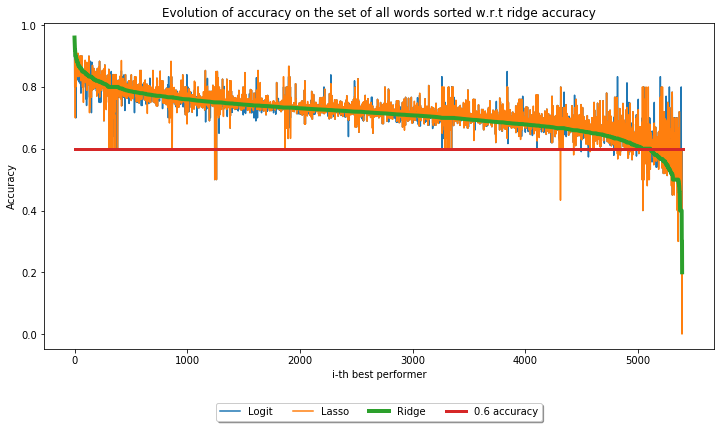

In [53]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

plt.plot(acc_log_best_perf,label='Logit')
plt.plot(acc_lasso_best_perf,label='Lasso')
plt.plot(acc_ridge_best_perf,label='Ridge',linewidth=4)




plt.plot([0,5400],[0.60,0.6],label='0.6 accuracy',linewidth=3)

plt.xlabel('i-th best performer')
plt.ylabel('Accuracy')
plt.title('Evolution of accuracy on the set of all words sorted w.r.t ridge accuracy')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

In [54]:
size_best_performers_las=[]
size_best_performers_rid=[]

size_best_performers_log=[]


acc_lasso_best_perf=[]
acc_ridge_best_perf=[]
acc_log_best_perf=[]

for i in range(len(sorted_results_lasso)):
    #las=sorted_results_lasso[i]
    #rid=sorted_results_ridge[i]
    log=sorted_results_log[i]
    #s_las=size[las[0]]
    #s_rid=size[rid[0]]
    s_log=size[log[0]]
    acc_las=log[1][0]
    acc_rid=log[1][2]
    acc_logit=log[1][4]
    acc_lasso_best_perf.append(acc_las)
    acc_ridge_best_perf.append(acc_rid)
    acc_log_best_perf.append(acc_logit)

    size_best_performers_las.append(s_rid)





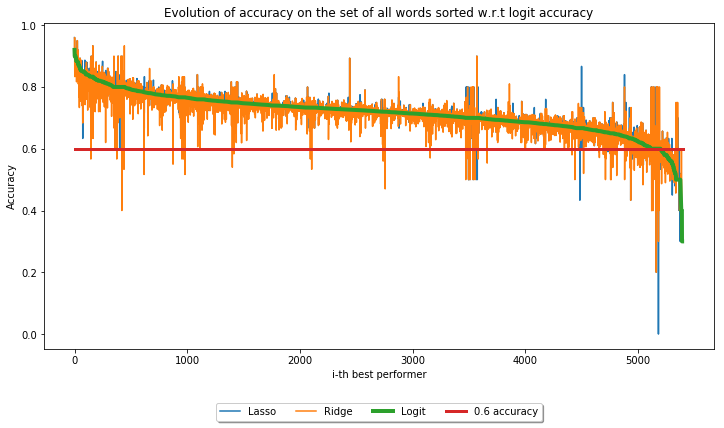

In [55]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

plt.plot(acc_lasso_best_perf,label='Lasso')
plt.plot(acc_ridge_best_perf,label='Ridge')

plt.plot(acc_log_best_perf,label='Logit',linewidth=4)




plt.plot([0,5400],[0.60,0.6],label='0.6 accuracy',linewidth=3)

plt.xlabel('i-th best performer')
plt.ylabel('Accuracy')
plt.title('Evolution of accuracy on the set of all words sorted w.r.t logit accuracy')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

In [56]:
k=0
for i in sorted_results_log:
    if size[i[0]]>=0 and size[i[0]]<1000:
        k+=1
        x,y=create_dataset(file,i[0][10:])
        print(i[0][10:-4].replace('_','\\textunderscore ')+'&'+str(i[1][4])+'&'+str(size[i[0]])+'&'+str(y.mean())+'\\'+'\\')
    if k>10:
        break

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


INTERESTING\textunderscore ER\textunderscore 2.0&0.9199999999999999&22&0.09090909090909091\\
INTERESTING\textunderscore AH\textunderscore 4.0&0.9099999999999999&22&0.09090909090909091\\
INDIVIDUALLY\textunderscore IH\textunderscore 3.0&0.9&19&0.10526315789473684\\
AMBIGUITY\textunderscore UW\textunderscore 3.0&0.9&50&0.11\\
STARTING\textunderscore AH\textunderscore 2.0&0.9&17&0.11764705882352941\\
ARGUING\textunderscore AH\textunderscore 3.0&0.9&29&0.13793103448275862\\
RECEIVE\textunderscore IY\textunderscore 1.0&0.9&28&0.125\\
AMBIGUITY\textunderscore IH\textunderscore 2.0&0.9&50&0.11\\
AMBIGUITY\textunderscore AH\textunderscore 4.0&0.9&50&0.11\\
TESTIFY\textunderscore EH\textunderscore 1.0&0.9&38&0.10526315789473684\\
AMBIGUITY\textunderscore IY\textunderscore 5.0&0.8955555555555555&48&0.10416666666666667\\


In [57]:
k=0
for i in sorted_results_ridge:
    if size[i[0]]>40 and size[i[0]]<100:
        k+=1
        print(i[0][10:-4]+' has a ridge accuracy of '+str(i[1][2])+' and a size of '+str(size[i[0]]))
        x,y=create_dataset(file,i[0][10:])
        print(y.mean())
    if k>20:
        break

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


AMBIGUITY_IH_2.0 has a ridge accuracy of 0.9 and a size of 50
0.11
AMBIGUITY_IY_5.0 has a ridge accuracy of 0.8755555555555556 and a size of 48
0.10416666666666667
EXAMINATION_IH_1.0 has a ridge accuracy of 0.8636363636363636 and a size of 52
0.15384615384615385
EXAMINATION_AE_2.0 has a ridge accuracy of 0.8636363636363636 and a size of 51
0.1568627450980392
CLOSER_ER_2.0 has a ridge accuracy of 0.8618181818181817 and a size of 52
0.15384615384615385
EXAMINATION_EY_4.0 has a ridge accuracy of 0.8600000000000001 and a size of 50
0.16
AMBIGUITY_UW_3.0 has a ridge accuracy of 0.86 and a size of 50
0.11
AMBIGUITY_AE_1.0 has a ridge accuracy of 0.86 and a size of 50
0.11
EXAMINATION_AH_3.0 has a ridge accuracy of 0.86 and a size of 50
0.16
EXAMINATION_AH_5.0 has a ridge accuracy of 0.86 and a size of 50
0.16
AMBIGUITY_AH_4.0 has a ridge accuracy of 0.86 and a size of 50
0.11
SERIES_IH_1.0 has a ridge accuracy of 0.8551282051282051 and a size of 63
0.16666666666666666
CORPORATION_ER_2.0 has 

In [58]:
acc_lasso[-1]

0.7351528905876732

In [59]:
acc_ridge[-1]

0.7340659340659341

In [60]:
acc_log[-1]

0.7351528905876732

In [61]:
d_size={}
for i in range(len(acc_log_all)):
    s=x_axis[i]
    if s in d_size:
        d_size[s]+=1
    else:
        d_size[s]=1
        
d_variance_las={}
d_variance_rid={}
d_variance_log={}
for j in range(len(acc_log_all)):
    s=x_axis[j]
    log=acc_log_all[j]
    las=acc_lasso_allpoints[j]
    rid=acc_ridge_all[j]
    if s in d_variance_las:
        d_variance_las[s]+=(las-d_average_acc[s][1])**2
    else:
        d_variance_las[s]=(las-d_average_acc[s][1])**2
    if s in d_variance_rid:
        d_variance_rid[s]+=(las-d_average_acc[s][2])**2
    else:
        d_variance_rid[s]=(las-d_average_acc[s][2])**2
    if s in d_variance_log:
        d_variance_log[s]+=(las-d_average_acc[s][3])**2
    else:
        d_variance_log[s]=(las-d_average_acc[s][3])**2

In [62]:
list_size=[]
list_var_las=[]
list_var_rid=[]
list_var_log=[]

for key in d_variance_las:
    list_size.append(key)
    list_var_las.append(d_variance_las[key]/d_average_acc[key][0])
    list_var_rid.append(d_variance_rid[key]/d_average_acc[key][0])  
    list_var_log.append(d_variance_log[key]/d_average_acc[key][0])

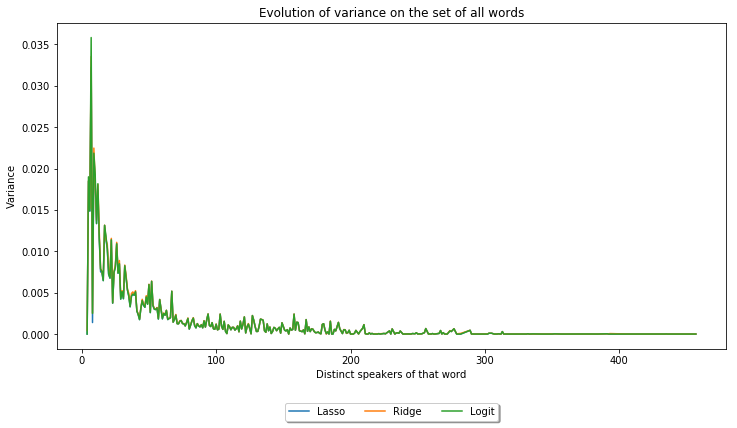

In [63]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

plt.plot(list_size,list_var_las,label='Lasso')
plt.plot(list_size,list_var_rid,label='Ridge')


plt.plot(list_size,list_var_log,label='Logit')




plt.xlabel('Distinct speakers of that word')
plt.ylabel('Variance')
plt.title('Evolution of variance on the set of all words')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

In [96]:
def optimal_lambda_lasso(s_lasso):
    lambda_lasso=lambdas[list(s_lasso).index(max(s_lasso))]
    return lambda_lasso

def confusion_matrix_regressor(type_of_regressor,x,y,lambda_reg,split_size=5):
    if split_size>len(y):
        if len(y)>1:
            split_size=len(y)
        else:
            return -1
        split_size=len(y)
    kf=KFold(n_splits=split_size)
    ConfM_total=0
    for train_index, test_index in kf.split(x):
        history=[]
        X_train, X_test = x.T[train_index].T, x.T[test_index].T
        y_train, y_test = y.T[train_index].T, y.T[test_index].T
        if type_of_regressor=='Ridge':
            lr=Ridge(alpha=lambda_reg,normalize=True)
        elif type_of_regressor=='Lasso':
            lr=Lasso(alpha=lambda_reg,normalize=False)
        else:
            lr=LogisticRegression(C=1/lambda_reg)
            y_train=y_train.astype(int)
            y_test=y_test.astype(int)
        lr.fit(X_train,y_train)
        y_predict=lr.predict(X_test)
        y_train_predicted=lr.predict(X_train)
        threshold=optimal_cut(y_train,y_train_predicted)
        y_predict[y_predict>threshold]=1
        y_predict[y_predict<=threshold]=0
        y_predict=list(y_predict.astype(int))
        y_test=list(y_test.astype(int))
        ConfM=skm.confusion_matrix(y_test,y_predict)
        ConfM_total+=len(y_test)*ConfM
    ConfM_total=ConfM_total/len(y)
    return ConfM_total


def confusion_matrix_lasso(d):
    k=0
    results={} 

    for file in d:
        results[file]=[]
        try:
            if k%100==0:
                print(str(100*k/len(d))+"% complete")
            n=size[file]
            if n<4:
                print(file+"was too small")
            else:
                x,y=create_dataset(file[:10],file[10:])
                s_lasso=score_regressor('Lasso',x,y,lambdas)
                lambda_lasso=optimal_lambda_lasso(s_lasso)
                ConfM=confusion_matrix_regressor('Lasso',x,y,lambda_lasso)
                results[file]=ConfM
                k+=1
        except ValueError:
            oops=1
    return results

In [139]:
best=[]
k=0
moy=0
for e in sorted_results_lasso:
    if e[1][0]>0.8:
        best.append(e[0])
        moy+=e[1][0]
        k+=1
moy/k

0.8376617270458929

In [140]:
results=confusion_matrix_lasso(best)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.0% complete
28.011204481792717% complete
56.022408963585434% complete


//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [135]:
C=[[0,0],[0,0]]
total=0
for key in results:
    n=size[key]
    try:
        C+=n*results[key]
        total+=n
    except ValueError:
        pass
Confusion_matrix=C/total

In [136]:
Confusion_matrix/sum(sum(Confusion_matrix))

array([[0.346, 0.205],
       [0.235, 0.213]])

In [137]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    acc = np.diag(cm).sum() / float(cm.sum())
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('{},Acc={}'.format(title, acc))
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.round(cm[i, j],3),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


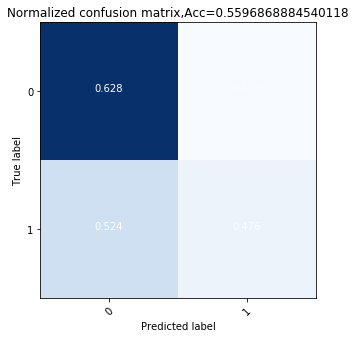

In [138]:
np.set_printoptions(precision=3)
plt.figure(figsize = (5,5))
plot_confusion_matrix(Confusion_matrix, classes=range(2), normalize=True,
                      title='Normalized confusion matrix')

plt.show()


In [110]:
Confusion_matrix

array([[20.015,  0.265],
       [ 7.724,  0.163]])

In [2]:
def file_ideo(fname):
    d={}
    with open(fname) as f:
        for i, l in enumerate(f):
            try:
                d[l.split(',')[0]]+=1
            except KeyError:
                d[l.split(',')[0]]=1
    return d

def sorted_ideo(folder):
    len_file={}
    for filename in os.listdir(folder):
        d=file_ideo(folder+filename)
        for key in d:
            try:
                len_file[key]+=d[key]
            except KeyError:
                len_file[key]=d[key]
    sorted_len_file=sorted(len_file.items(), key=lambda x: -x[1])
    return sorted_len_file

In [29]:
d={}
k=0
p=0
for i in sorted_ideo(file):
    d[float(i[0])]=i[1]
    if float(i[0])<0.5:
        k+=1
    p+=1

1.1238157894736842

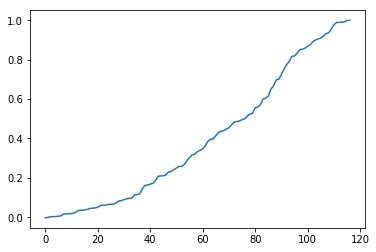

In [31]:
plt.plot(sorted(l))
0.73/(k/p)

<Container object of 117 artists>

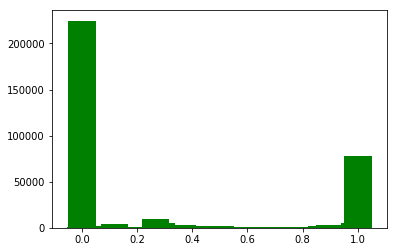

In [34]:
plt.bar(d.keys(), d.values(), width=.1, color='g')

In [35]:
del d[0]

<Container object of 116 artists>

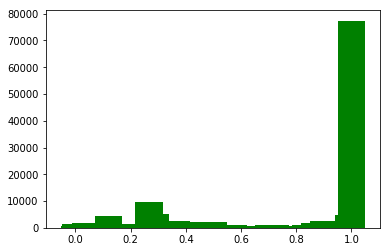

In [36]:
plt.bar(d.keys(), d.values(), width=.1, color='g')

In [37]:
del d[1]

<Container object of 115 artists>

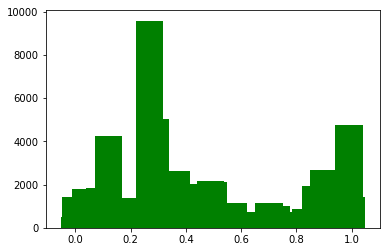

In [38]:
plt.bar(d.keys(), d.values(), width=.1, color='g')

In [39]:
d

{-0.0032147828574918907: 503,
 0.002472799208704253: 1411,
 0.003323262839879154: 585,
 0.004: 580,
 0.0054466230936819175: 778,
 0.007246376811594203: 852,
 0.016722408026755852: 657,
 0.01737228245385574: 862,
 0.01825117263784198: 797,
 0.018518518518518517: 666,
 0.02082912411450186: 417,
 0.029940119760479042: 607,
 0.03540179922937689: 1254,
 0.03568369968598344: 668,
 0.037286724927174365: 1792,
 0.03986826139712255: 567,
 0.044642857142857144: 891,
 0.0461236316271587: 484,
 0.047573739295908656: 1810,
 0.051490514905149054: 852,
 0.05963228348710511: 528,
 0.06097560975609756: 743,
 0.06119523026890933: 528,
 0.06573290878638645: 779,
 0.0662940654052643: 770,
 0.0664819944598338: 770,
 0.07261164901661495: 958,
 0.08250825082508251: 813,
 0.0847457627118644: 884,
 0.08950545727963642: 1846,
 0.09401709401709402: 737,
 0.09613819705639245: 837,
 0.09732706075762634: 894,
 0.11457431215500621: 717,
 0.11518225545177777: 569,
 0.11904761904761904: 4237,
 0.14556962025316456: 821